In [ ]:
%pip install pymilvus[milvus_lite]
%pip install transformers
%pip install datasets
%pip install sentence-transformers
%pip install ragas
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.3/284.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 154.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing

In [ ]:
# Load required Libraries
import pandas as pd
import numpy as np
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
import re
import string

from datetime import datetime

from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import pipeline

# Read Passages from the Datasets and Drop rows if they are NA or empty

In [ ]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(f"Original dataset shape: {passages.shape}")
# Clean data
passages = passages.dropna(subset=['passage'])
passages = passages[passages['passage'].str.strip() != '']
print(f"Cleaned dataset shape: {passages.shape}")
passages.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Original dataset shape: (3200, 1)
Cleaned dataset shape: (3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# Dataset EDA


In [ ]:
# Analyze passage lengths before indexing

print("Dataseet EDA")
print(f"Total passages: {len(passages)}")
print(f"Dataset columns: {passages.columns.tolist()}")

# Calculate passage lengths
passages['passage_length'] = passages['passage'].str.len()
passages['word_count'] = passages['passage'].str.split().str.len()

print(f"\nPassage Length Statistics - Characters:")
print(f"Min length: {passages['passage_length'].min()}")
print(f"Max length: {passages['passage_length'].max()}")
print(f"Mean length: {passages['passage_length'].mean():.2f}")
print(f"Median length: {passages['passage_length'].median():.2f}")
print(f"Std length: {passages['passage_length'].std():.2f}")

print(f"\nWord Count Statistics:")
print(f"Min words: {passages['word_count'].min()}")
print(f"Max words: {passages['word_count'].max()}")
print(f"Mean words: {passages['word_count'].mean():.2f}")
print(f"Median words: {passages['word_count'].median():.2f}")

# Distribution analysis
print(f"\nPassage Length Distribution:")
print(passages['passage_length'].describe())

Dataseet EDA
Total passages: 3200
Dataset columns: ['passage']

Passage Length Statistics - Characters:
Min length: 1
Max length: 2515
Mean length: 389.85
Median length: 299.00
Std length: 348.37

Word Count Statistics:
Min words: 1
Max words: 425
Mean words: 62.10
Median words: 48.00

Passage Length Distribution:
count        3200.0
mean     389.848125
std      348.368869
min             1.0
25%           108.0
50%           299.0
75%           574.0
max          2515.0
Name: passage_length, dtype: Float64


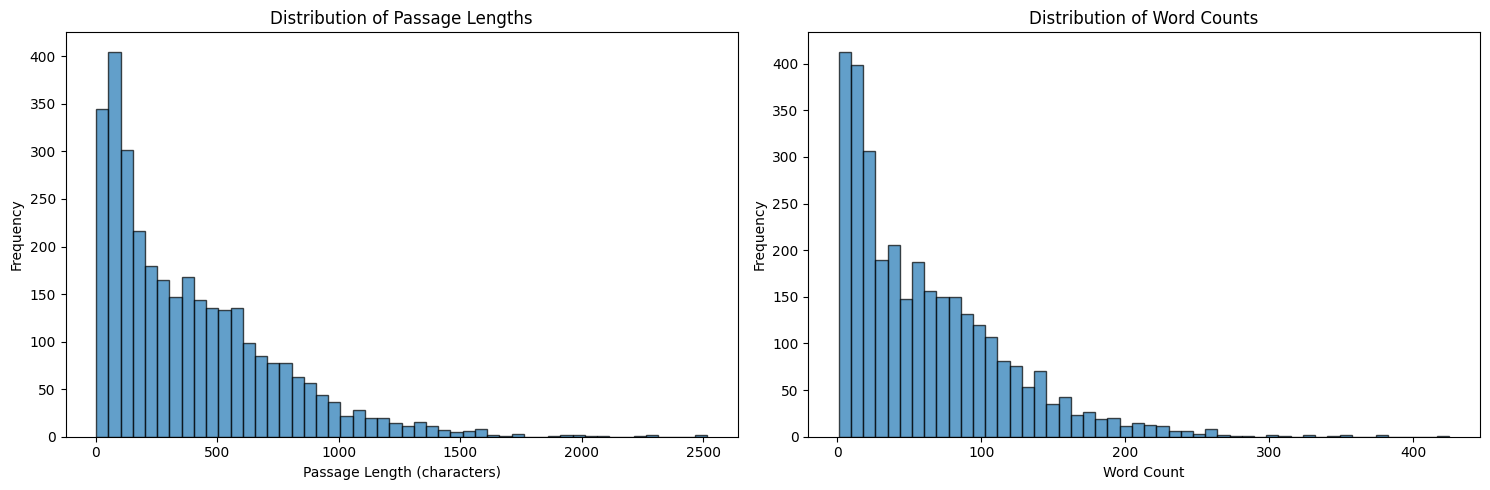

In [ ]:
# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(passages['passage_length'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Passage Length (characters)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Passage Lengths')

ax2.hist(passages['word_count'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Word Counts')

plt.tight_layout()
plt.show()

In [ ]:
# Sample passages
print(f"\nSample passages:")
print("Short passage example:")
short_passage = passages[passages['passage_length'] < 100]['passage'].iloc[0] if len(passages[passages['passage_length'] < 100]) > 0 else "No short passages found"
print(f"Length: {len(short_passage)} chars")
print(f"Content: {short_passage[:200]}...")

print("\nMedium passage example:")
medium_mask = (passages['passage_length'] >= 200) & (passages['passage_length'] <= 400)
medium_passage = passages[medium_mask]['passage'].iloc[0] if len(passages[medium_mask]) > 0 else "No medium passages found"
print(f"Length: {len(medium_passage)} chars")
print(f"Content: {medium_passage[:200]}...")

print("\nLong passage example:")
long_passage = passages[passages['passage_length'] > 600]['passage'].iloc[0] if len(passages[passages['passage_length'] > 600]) > 0 else "No long passages found"
print(f"Length: {len(long_passage)} chars")
print(f"Content: {long_passage[:200]}...")


Sample passages:
Short passage example:
Length: 25 chars
Content: RÃ­o de la Plata in 1603....

Medium passage example:
Length: 250 chars
Content: Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in...

Long passage example:
Length: 703 chars
Content: Europeans arrived in the territory of present-day Uruguay in the year 1536, but the absence of gold and silver limited settlement in the region during the 16th and 17th centuries. Uruguay became a zon...
